In [1]:
import sys
import pandas as pd
import numpy as np
import os
from functools import reduce
import datetime
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import (
    auc,
    accuracy_score,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    average_precision_score,
)

sys.path.append("..")

from explainer import ShiftExplainer
from experiments import *
from utils.constants import *
from utils.plot_utils import errorfill, plot_roc, plot_pr, linestyles, markers, colors, brightness, colorscale
from utils.utils import import_dataset_hospital, run_shift_experiment, get_data
from baseline_models.static.utils import run_model

# Parameters #

In [2]:
PATH = "/mnt/nfs/project/delirium/drift_exp"
DATASET = "gemini"
SAMPLES = [10, 20, 50, 100, 200, 500, 1000]
RANDOM_RUNS = 5
SIGN_LEVEL = 0.05
CALC_ACC = True
SAMPLES = [10, 20, 50, 100, 200, 500, 1000]
DR_TECHNIQUES = ["NoRed", "SRP", "PCA", "kPCA", "Isomap","BBSDs_FFNN"]
MD_TESTS = [ "LSDD", "MMD", "LK","Classifier"]

# Input Parameters #

In [3]:
SHIFT = input("Select experiment: ") 
OUTCOME = input("Select outcome variable: ") # one of ["length_of_stay_in_er", "mortality_in_hospital"]
if SHIFT != "hosp_type":
    HOSPITAL = [input("Select hospital: ")] # one of ["SMH", "MSH", "THPC", "THPM", "UHNTG", "UHNTW"]

NA_CUTOFF = 0.60

if SHIFT == "covid":
    EXPERIMENTS = ["pre-covid", "covid"]

if SHIFT == "seasonal":
    EXPERIMENTS = ["summer", "winter", "seasonal"]

Select experiment:  covid
Select outcome variable:  length_of_stay_in_er
Select hospital:  SMH


In [5]:
HOSPITAL = ["SMH", "MSH", "THPC", "THPM", "UHNTG", "UHNTW"]

# Drift Tests #

In [6]:
# Run shift experiments
if os.path.exists(os.path.join(PATH, '_'.join([SHIFT, '_'.join(HOSPITAL),"mean_dr_md_pval.pkl"]))):
    with open(os.path.join(PATH, '_'.join([SHIFT, '_'.join(HOSPITAL),"mean_dr_md_pval.pkl"])), "rb") as f:
        mean_dr_md_pval = pickle.load(f)
    with open(os.path.join(PATH, '_'.join([SHIFT, '_'.join(HOSPITAL),"mean_dr_md_dist.pkl"])), "rb") as f:
        mean_dr_md_dist = pickle.load(f)
else:
    mean_dr_md_pval = np.ones(
        (len(EXPERIMENTS), len(DR_TECHNIQUES), len(MD_TESTS), len(SAMPLES))
    ) * (-1)
    mean_dr_md_dist = np.ones(
        (len(EXPERIMENTS), len(DR_TECHNIQUES), len(MD_TESTS), len(SAMPLES))
    ) * (-1)

if os.path.exists(os.path.join(PATH, '_'.join([SHIFT, '_'.join(HOSPITAL),"std_dr_md_pval.pkl"]))):
    with open(os.path.join(PATH, '_'.join([SHIFT, '_'.join(HOSPITAL),"std_dr_md_pval.pkl"])), "rb") as f:
        std_dr_md_pval = pickle.load(f)
    with open(os.path.join(PATH, '_'.join([SHIFT, '_'.join(HOSPITAL),"std_dr_md_dist.pkl"])), "rb") as f:
        std_dr_md_dist = pickle.load(f)
        
else:
    std_dr_md_pval = np.ones(
        (len(EXPERIMENTS), len(DR_TECHNIQUES), len(MD_TESTS), len(SAMPLES))
    ) * (-1)
    std_dr_md_dist = np.ones(
        (len(EXPERIMENTS), len(DR_TECHNIQUES), len(MD_TESTS), len(SAMPLES))
    ) * (-1)

for si, SHIFT in enumerate(EXPERIMENTS):
    for di, DR_TECHNIQUE in enumerate(DR_TECHNIQUES):
        for mi, MD_TEST in enumerate(MD_TESTS):
            if np.any(mean_dr_md_pval[si, di, mi, :] == -1):
                print(
                    "{} | {} | {} | {}".format(
                        SHIFT, HOSPITAL, DR_TECHNIQUE, MD_TEST
                    )
                )
                try:
                    mean_p_vals, std_p_vals, mean_dist, std_dist = run_shift_experiment(
                        shift=SHIFT,
                        outcome=OUTCOME,
                        hospital=HOSPITAL,
                        path=PATH,
                        dr_technique=DR_TECHNIQUE,
                        md_test=MD_TEST,
                        samples=SAMPLES,
                        dataset=DATASET,
                        sign_level=SIGN_LEVEL,
                        na_cutoff=NA_CUTOFF,
                        random_runs=RANDOM_RUNS,
                        calc_acc=CALC_ACC,
                        bucket_size=6, 
                        window=6
                    )
                    mean_dr_md_pval[si, di, mi, :] = mean_p_vals
                    std_dr_md_pval[si, di, mi, :] = std_p_vals
                    mean_dr_md_dist[si, di, mi, :] = mean_dist
                    std_dr_md_dist[si, di, mi, :] = std_dist
                except ValueError as e:
                    print("Value Error")
                    pass


pre-covid | ['SMH', 'MSH', 'THPC', 'THPM', 'UHNTG', 'UHNTW'] | NoRed | LSDD
pre-covid | ['SMH', 'MSH', 'THPC', 'THPM', 'UHNTG', 'UHNTW'] | NoRed | MMD
pre-covid | ['SMH', 'MSH', 'THPC', 'THPM', 'UHNTG', 'UHNTW'] | NoRed | LK
pre-covid | ['SMH', 'MSH', 'THPC', 'THPM', 'UHNTG', 'UHNTW'] | NoRed | Classifier
Value Error
pre-covid | ['SMH', 'MSH', 'THPC', 'THPM', 'UHNTG', 'UHNTW'] | SRP | LSDD
pre-covid | ['SMH', 'MSH', 'THPC', 'THPM', 'UHNTG', 'UHNTW'] | SRP | MMD
pre-covid | ['SMH', 'MSH', 'THPC', 'THPM', 'UHNTG', 'UHNTW'] | SRP | LK
pre-covid | ['SMH', 'MSH', 'THPC', 'THPM', 'UHNTG', 'UHNTW'] | SRP | Classifier
pre-covid | ['SMH', 'MSH', 'THPC', 'THPM', 'UHNTG', 'UHNTW'] | PCA | LSDD
pre-covid | ['SMH', 'MSH', 'THPC', 'THPM', 'UHNTG', 'UHNTW'] | PCA | MMD
pre-covid | ['SMH', 'MSH', 'THPC', 'THPM', 'UHNTG', 'UHNTW'] | PCA | LK
pre-covid | ['SMH', 'MSH', 'THPC', 'THPM', 'UHNTG', 'UHNTW'] | PCA | Classifier
pre-covid | ['SMH', 'MSH', 'THPC', 'THPM', 'UHNTG', 'UHNTW'] | kPCA | LSDD
Value Er

The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
Changing the sparsity structure of a

covid | ['SMH', 'MSH', 'THPC', 'THPM', 'UHNTG', 'UHNTW'] | Isomap | MMD


The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
Changing the sparsity structure of a

covid | ['SMH', 'MSH', 'THPC', 'THPM', 'UHNTG', 'UHNTW'] | Isomap | LK


The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
Changing the sparsity structure of a

covid | ['SMH', 'MSH', 'THPC', 'THPM', 'UHNTG', 'UHNTW'] | Isomap | Classifier


The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
Changing the sparsity structure of a

covid | ['SMH', 'MSH', 'THPC', 'THPM', 'UHNTG', 'UHNTW'] | BBSDs_FFNN | LSDD
covid | ['SMH', 'MSH', 'THPC', 'THPM', 'UHNTG', 'UHNTW'] | BBSDs_FFNN | MMD
covid | ['SMH', 'MSH', 'THPC', 'THPM', 'UHNTG', 'UHNTW'] | BBSDs_FFNN | LK
covid | ['SMH', 'MSH', 'THPC', 'THPM', 'UHNTG', 'UHNTW'] | BBSDs_FFNN | Classifier
Value Error


Select Pre-Processing:  NoRed
Select Two-Sample Testing:  LSDD


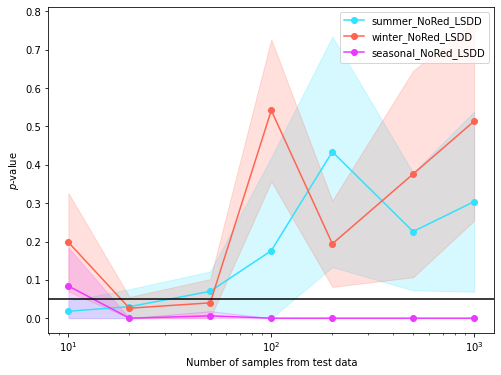

In [14]:
DIM_RED = input("Select Pre-Processing: ")
MD_TEST = input("Select Two-Sample Testing: ")

fig = plt.figure(figsize=(8, 6))
for si, shift in enumerate(EXPERIMENTS):
    for di, dr_technique in enumerate(DR_TECHNIQUES):
        for mi, md_test in enumerate(MD_TESTS):
            if (
                    dr_technique == DIM_RED
                    and md_test == MD_TEST
            ):
                errorfill(
                        np.array(SAMPLES),
                        mean_dr_md_pval[si, di, mi, :],
                        std_dr_md_pval[si, di, mi, :],
                        fmt=linestyles[di] + markers[di],
                        color=colorscale(colors[si], brightness[mi]),
                        label="%s" % "_".join([shift, dr_technique, md_test]),
                )
plt.xlabel("Number of samples from test data")
plt.ylabel("$p$-value")
plt.axhline(y=SIGN_LEVEL, color="k")
plt.legend()
plt.show()

# Run shift experiments
if not os.path.exists(os.path.join(PATH, '_'.join([SHIFT, '_'.join(HOSPITAL),"mean_dr_md_pval.pkl"]))):
    with open(os.path.join(PATH, '_'.join([SHIFT, '_'.join(HOSPITAL),"mean_dr_md_pval.pkl"])), "wb") as f:
        pickle.dump(mean_dr_md_pval, f)
    with open(os.path.join(PATH, '_'.join([SHIFT, '_'.join(HOSPITAL),"mean_dr_md_dist.pkl"])), "wb") as f:
        pickle.dump(mean_dr_md_dist, f)
if not os.path.exists(os.path.join(PATH, '_'.join([SHIFT, '_'.join(HOSPITAL),"std_dr_md_pval.pkl"]))):
    with open(os.path.join(PATH, '_'.join([SHIFT, '_'.join(HOSPITAL),"std_dr_md_pval.pkl"])), "wb") as f:
        pickle.dump(std_dr_md_pval, f)
    with open(os.path.join(PATH, '_'.join([SHIFT, '_'.join(HOSPITAL),"std_dr_md_dist.pkl"])), "wb") as f:
        pickle.dump(std_dr_md_dist, f)

# Build Model #

In [14]:
(
    (X_train, y_train),
    (X_val, y_val),
    (X_test, y_test),
    feats,
    orig_dims,
) = import_dataset_hospital(
    SHIFT, OUTCOME, HOSPITAL, NA_CUTOFF, shuffle=True
)

MODEL_NAME = input("Select Model: ")
MODEL_PATH = PATH + "_".join([SHIFT, OUTCOME, '_'.join(HOSPITAL), MODEL_NAME]) + ".pkl"
if os.path.exists(MODEL_PATH):
    optimised_model = pickle.load(open(MODEL_PATH, "rb"))
else:
    optimised_model = run_model(MODEL_NAME, X_train, y_train, X_val, y_val)

Select Model:  lr


Fitting model with C: 0.1
Fitting model with C: 0.01
Fitting model with C: 0.001
Fitting model with C: 0.0001
Fitting model with C: 1e-05
Fitting model with C: 1e-06
Fitting model with C: 1e-07
Best C: 0.1


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

### Performance on Source Data ###

<AxesSubplot:title={'center':'Average Precision: 0.962282'}, xlabel='Recall', ylabel='Precision'>

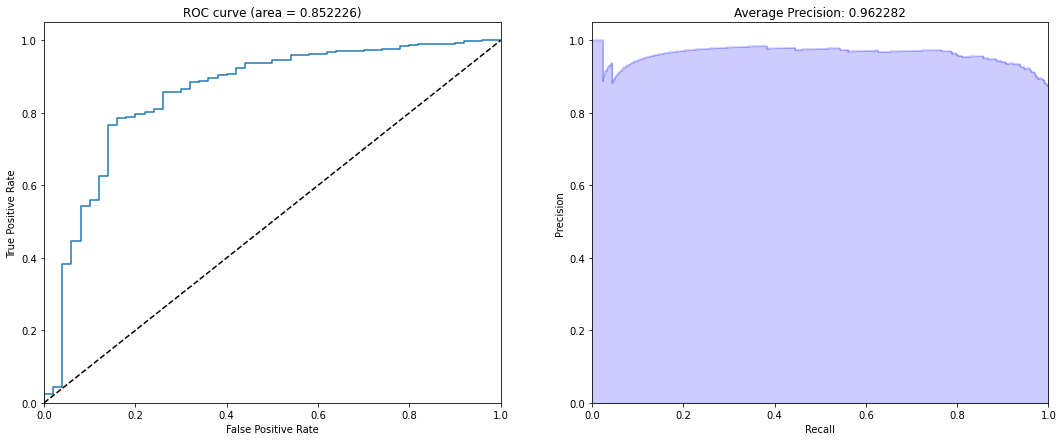

In [17]:
y_pred_prob = optimised_model.predict_proba(X_val)[:, 1]

fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob, pos_label=1)
roc_auc = auc(fpr, tpr)
precision, recall, thresholds = precision_recall_curve(y_val, y_pred_prob)
avg_pr = average_precision_score(y_val, y_pred_prob)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 7))
plot_roc(ax[0], fpr, tpr, roc_auc)
plot_pr(ax[1], recall, precision, avg_pr)

### Performance on Target Data ###

<AxesSubplot:title={'center':'Average Precision: 0.913662'}, xlabel='Recall', ylabel='Precision'>

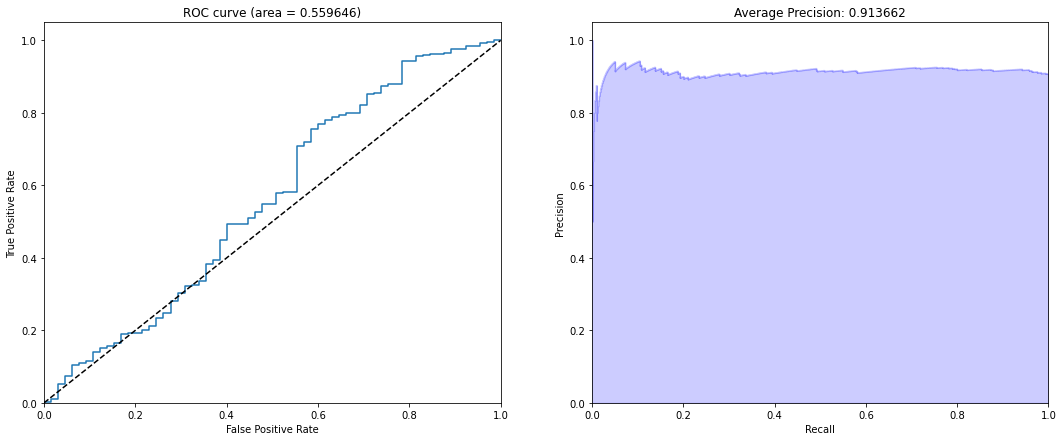

In [18]:
y_pred_prob = optimised_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label=1)
roc_auc = auc(fpr, tpr)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
avg_pr = average_precision_score(y_test, y_pred_prob)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 7))
plot_roc(ax[0], fpr, tpr, roc_auc)
plot_pr(ax[1], recall, precision, avg_pr)

## Performance by Sample Size ##

In [19]:
samp_metrics = np.ones((len(SAMPLES), RANDOM_RUNS, 2, 2)) * (-1)
for si, sample in enumerate(SAMPLES):
    for i in range(0, RANDOM_RUNS - 1):
        i = int(i)
        np.random.seed(i)
        X_val, y_val = unison_shuffled_copies(X_val, y_val)
        X_test, y_test = unison_shuffled_copies(X_test, y_test)

        y_val_pred_prob = optimised_model.predict_proba(X_val[:sample])[:, 1]
        val_fpr, val_tpr, val_thresholds = roc_curve(
            y_val[:sample], y_val_pred_prob, pos_label=1
        )
        val_roc_auc = auc(val_fpr, val_tpr)
        val_avg_pr = average_precision_score(y_val[:sample], y_val_pred_prob)

        y_test_pred_prob = optimised_model.predict_proba(X_test[:sample])[:, 1]
        test_fpr, test_tpr, test_thresholds = roc_curve(
            y_test[:sample], y_test_pred_prob, pos_label=1
        )
        test_roc_auc = auc(test_fpr, test_tpr)
        test_avg_pr = average_precision_score(y_test[:sample], y_test_pred_prob)

        samp_metrics[si, i, 0, :] = [val_roc_auc, val_avg_pr]
        samp_metrics[si, i, 1, :] = [test_roc_auc, test_avg_pr]

    mean_samp_metrics = np.mean(samp_metrics, axis=1)
    std_samp_metrics = np.std(samp_metrics, axis=1)

torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
No negative samples in y_true, false positive value should be meaningless
No negative samples in y_true, false positive value should be meaningless
No negative samples in y_true, false positive value should be meaningless
No negative samples in y_true, false positive value should be meaningless
No negative samples in y_true, false positive value should be meaningless
torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
torch.range is deprecated and will b

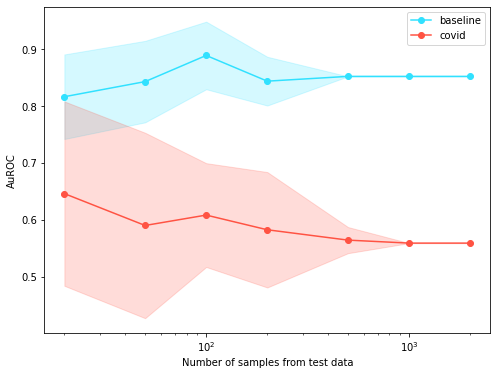

In [21]:
fig = plt.figure(figsize=(8, 6))
for si, shift in enumerate(["baseline", SHIFT]):
    for mi, metric in enumerate(["AuROC", "Avg Pr"]):
        if metric == "AuROC":
            errorfill(
                np.array(SAMPLES[1:]),
                mean_samp_metrics[1:, si, mi],
                std_samp_metrics[1:, si, mi],
                fmt=linestyles[mi] + markers[mi],
                color=colorscale(colors[si], brightness[si]),
                label="%s" % "_".join([shift]),
            )
plt.xlabel("Number of samples from test data")
plt.ylabel("AuROC")
plt.legend()
plt.show()

## Explain Difference in Model Predictions ## 

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


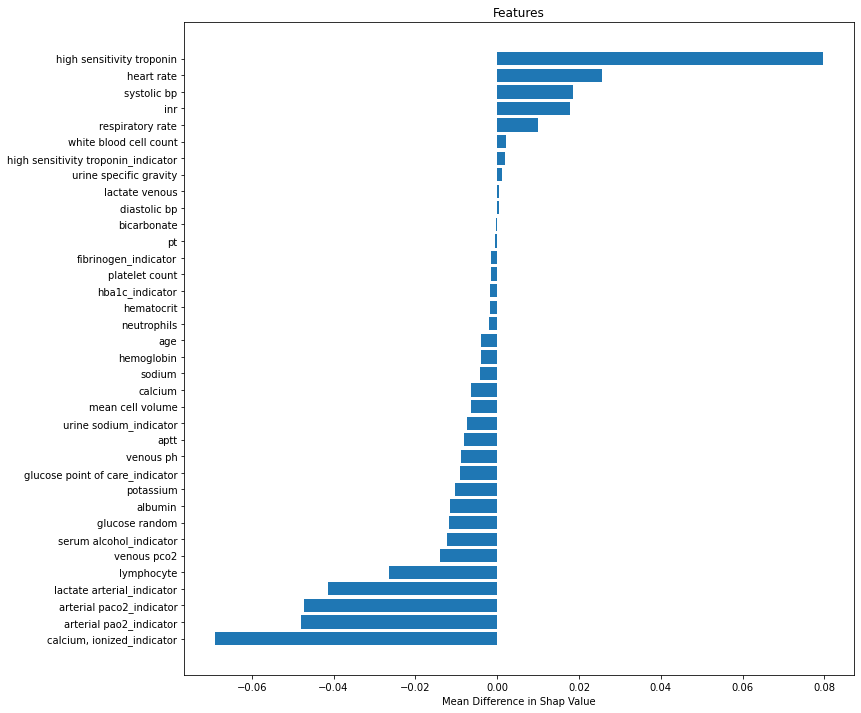

In [22]:
explainer = ShiftExplainer(optimised_model)
explainer.get_explainer()

X_val_df = pd.DataFrame(X_val, columns=feats)
val_shap_values = explainer.get_shap_values(X_val_df)
X_test_df = pd.DataFrame(X_test, columns=feats)
test_shap_values = explainer.get_shap_values(X_test_df)

diff = np.mean(np.abs(test_shap_values.values), axis=0) - np.mean(
    np.abs(val_shap_values.values), axis=0
)
diff_sorted, feats_sorted = zip(*sorted(zip(diff, feats), reverse=True))
diff_sorted, feats_sorted = zip(
    *(((x, y) for x, y in zip(diff_sorted, feats_sorted) if x != 0))
)
fig, ax = plt.subplots(figsize=(12, 12))
y_pos = np.arange(len(diff_sorted))
ax.barh(y_pos, diff_sorted, align="center")
ax.set_yticks(y_pos, labels=feats_sorted)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel("Mean Difference in Shap Value")
ax.set_title("Features")
plt.show()